# 3D Keypoint Reprojection on a HD view

In this example, we reproject 3D body/face/hands keypoints onto a HD view.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

# For camera projection (with distortion)
import panutils

In [2]:
# Setup paths
data_path = '../'
seq_name = '171204_pose1_sample'

hd_skel_json_path = data_path+seq_name+'/hdPose3d_stage1_coco19/'
hd_face_json_path = data_path+seq_name+'/hdFace3d/'
hd_hand_json_path = data_path+seq_name+'/hdHand3d/'
hd_img_path = data_path+seq_name+'/hdImgs/'

colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()

## Load camera calibration parameters

In [3]:
# Load camera calibration parameters
with open(data_path+seq_name+'/calibration_{0}.json'.format(seq_name)) as cfile:
    calib = json.load(cfile)

# Cameras are identified by a tuple of (panel#,node#)
cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}

# Convert data into numpy arrays for convenience
for k,cam in cameras.iteritems():    
    cam['K'] = np.matrix(cam['K'])
    cam['distCoef'] = np.array(cam['distCoef'])
    cam['R'] = np.matrix(cam['R'])
    cam['t'] = np.array(cam['t']).reshape((3,1))
    

## Select Image Frame and Camera view

In [4]:
# Select HD frame
hd_idx = 0

# Select an HD camera (0,0) - (0,30), where the zero in the first index means HD camera 
cam = cameras[(0,5)]


# Load the corresponding HD image
image_path = hd_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.jpg'.format(cam['panel'], cam['node'], hd_idx)
im = plt.imread(image_path)
plt.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## Reproject 3D Body Keypoint onto the first HD camera

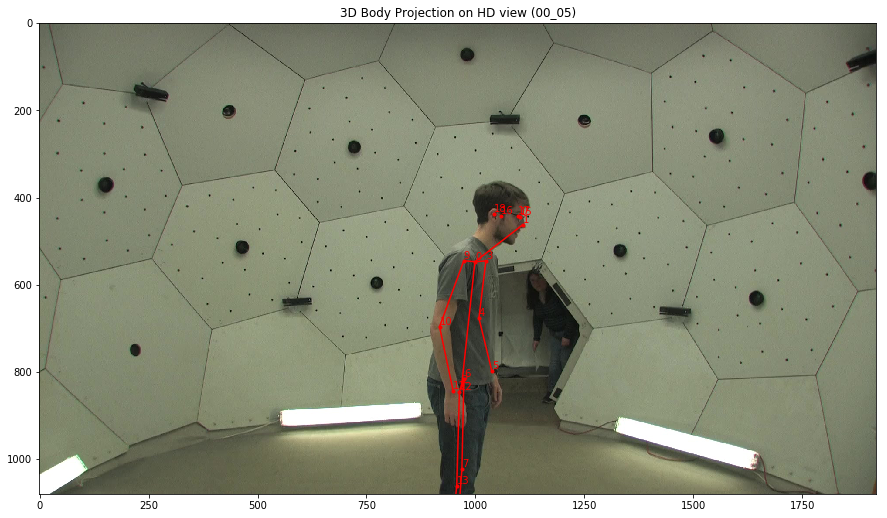

In [5]:
'''
## Reproject 3D Body Keypoint onto the first HD camera
'''

# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1
#plt.subplot(131)
plt.figure(figsize=(15,15))
plt.title('3D Body Projection on HD view ({0})'.format(cam['name']))
plt.imshow(im)
currentAxis = plt.gca()
currentAxis.set_autoscale_on(False)

try:
    # Load the json file with this frame's skeletons
    skel_json_fname = hd_skel_json_path+'body3DScene_{0:08d}.json'.format(hd_idx)
    with open(skel_json_fname) as dfile:
        bframe = json.load(dfile)

    # Cycle through all detected bodies
    for body in bframe['bodies']:
        
        # There are 19 3D joints, stored as an array [x1,y1,z1,c1,x2,y2,z2,c2,...]
        # where c1 ... c19 are per-joint detection confidences
        skel = np.array(body['joints19']).reshape((-1,4)).transpose()

        # Project skeleton into view (this is like cv2.projectPoints)
        pt = panutils.projectPoints(skel[0:3,:],
                      cam['K'], cam['R'], cam['t'], 
                      cam['distCoef'])

        # Show only points detected with confidence
        valid = skel[3,:]>0.1

        plt.plot(pt[0,valid], pt[1,valid], '.', color=colors[body['id']])

        # Plot edges for each bone
        for edge in body_edges:
            if valid[edge[0]] or valid[edge[1]]:
                plt.plot(pt[0,edge], pt[1,edge], color=colors[body['id']])

        # Show the joint numbers
        for ip in xrange(pt.shape[1]):
            if pt[0,ip]>=0 and pt[0,ip]<im.shape[1] and pt[1,ip]>=0 and pt[1,ip]<im.shape[0]:
                plt.text(pt[0,ip], pt[1,ip]-5, '{0}'.format(ip),color=colors[body['id']])
        
        plt.draw()
        
except IOError as e:
    print('Error reading {0}\n'.format(skel_json_fname)+e.strerror)



## Reproject 3D Face Keypoint onto the first HD camera

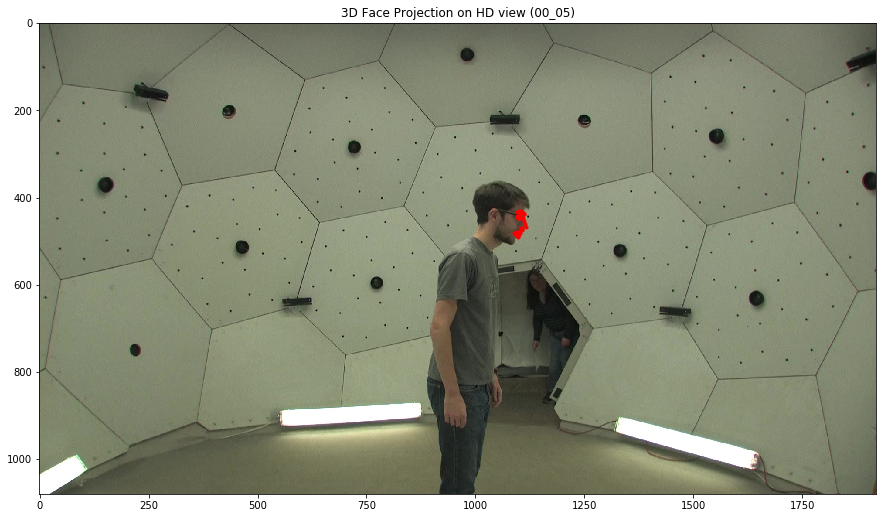

In [6]:

'''
## Reproject 3D Face Keypoint onto the first HD camera
'''
# Face keypoint orders follow Openpose keypoint output
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md
# Face outline points (0-16) are unstable
face_edges = np.array([ #[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[11,12],[12,13],[14,15],[15,16], #outline (ignored)
                [17,18],[18,19],[19,20],[20,21], #right eyebrow
                [22,23],[23,24],[24,25],[25,26], #left eyebrow
                [27,28],[28,29],[29,30],   #nose upper part
                [31,32],[32,33],[33,34],[34,35], #nose lower part
                [36,37],[37,38],[38,39],[39,40],[40,41],[41,36], #right eye
                [42,43],[43,44],[44,45],[45,46],[46,47],[47,42], #left eye
                [48,49],[49,50],[50,51],[51,52],[52,53],[53,54],[54,55],[55,56],[56,57],[57,58],[58,59],[59,48], #Lip outline
                [60,61],[61,62],[62,63],[63,64],[64,65],[65,66],[66,67],[67,60] #Lip inner line 
                ])
#plt.subplot(132)
plt.figure(figsize=(15,15))
plt.title('3D Face Projection on HD view ({0})'.format(cam['name']))
plt.imshow(im)
currentAxis = plt.gca()
currentAxis.set_autoscale_on(False)

try:
    # Load the json file with this frame's face
    face_json_fname = hd_face_json_path+'faceRecon3D_hd{0:08d}.json'.format(hd_idx)
    with open(face_json_fname) as dfile:
        fframe = json.load(dfile)

    # Cycle through all detected faces
    for face in fframe['people']:
        
        # 3D Face has 70 3D joints, stored as an array [x1,y1,z1,x2,y2,z2,...]
        face3d = np.array(face['face70']['landmarks']).reshape((-1,3)).transpose()

        # Project skeleton into view (this is like cv2.projectPoints)
        pt = panutils.projectPoints(face3d,
                      cam['K'], cam['R'], cam['t'], 
                      cam['distCoef'])

        # Show only points detected with confidence
        # Outline points (0-16) are unstable, so will be ignored
        plt.plot(pt[0,17:], pt[1,17:], '.', color=colors[face['id']])

        # Plot edges for each bone
        for edge in face_edges:
           plt.plot(pt[0,edge], pt[1,edge], color=colors[face['id']])

        #Uncomment the following to show the joint numbers
        '''
        for ip in xrange(pt.shape[1]):
            if pt[0,ip]>=0 and pt[0,ip]<im.shape[1] and pt[1,ip]>=0 and pt[1,ip]<im.shape[0]:
                plt.text(pt[0,ip], pt[1,ip]-5, '{0}'.format(ip),color=colors[face['id']])
        '''
        
        plt.draw()

except IOError as e:
    print('Error reading {0}\n'.format(face_json_fname)+e.strerror)


## Reproject 3D Hand Keypoint onto the first HD camera

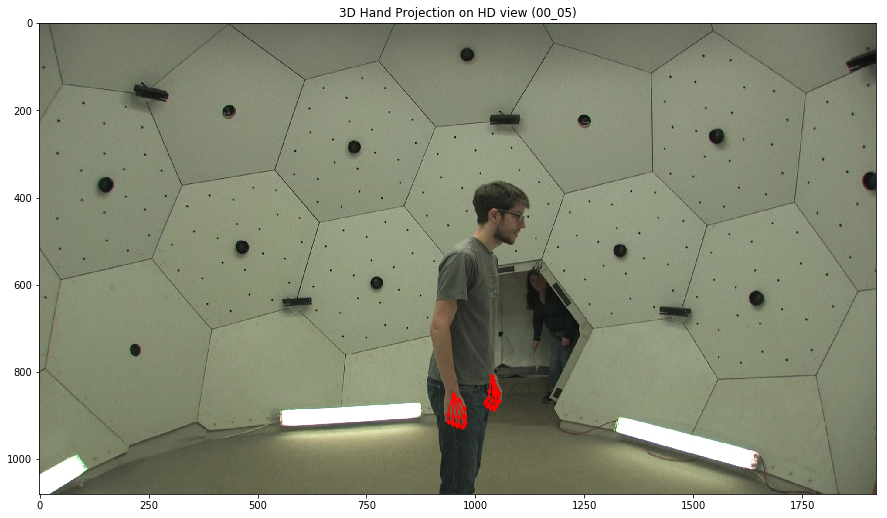

In [7]:

'''
## Reproject 3D Hand Keypoint onto the first HD camera
'''
# Joint orders follow Openpose keypoint output
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md
hand_edges = np.array([[0,1],[1,2],[2,3],[3,4],
                [0,5],[5,6],[6,7],[7,8],
                [0,9],[9,10],[10,11],[11,12],
                [0,13],[13,14],[14,15],[15,16],
                [0,17],[17,18],[18,19],[19,20]])

plt.figure(figsize=(15,15))
#plt.subplot(133)
plt.title('3D Hand Projection on HD view ({0})'.format(cam['name']))
plt.imshow(im)
currentAxis = plt.gca()
currentAxis.set_autoscale_on(False)

try:
    # Load the json file with this frame's face
    hand_json_fname = hd_hand_json_path+'handRecon3D_hd{0:08d}.json'.format(hd_idx)
    with open(hand_json_fname) as dfile:
        hframe = json.load(dfile)

    # Cycle through all detected hands
    for hand in hframe['people']:
        
        # 3D hands, right_hand and left_hand, have 21 3D joints, stored as an array [x1,y1,z1,x2,y2,z2,...]

        '''
        # Right hand
        '''
        hand3d = np.array(hand['right_hand']['landmarks']).reshape((-1,3)).transpose()

        # Project skeleton into view (this is like cv2.projectPoints)
        pt = panutils.projectPoints(hand3d,
                      cam['K'], cam['R'], cam['t'], 
                      cam['distCoef'])

        # Show only points detected with confidence
        #valid = skel[3,:]>0.1
        plt.plot(pt[0,:], pt[1,:], '.', color=colors[hand['id']])

        # Plot edges for each bone
        for edge in hand_edges:
            plt.plot(pt[0,edge], pt[1,edge], color=colors[hand['id']])

        #Uncomment the following to show the joint numbers
        '''
        for ip in xrange(pt.shape[1]):
            if pt[0,ip]>=0 and pt[0,ip]<im.shape[1] and pt[1,ip]>=0 and pt[1,ip]<im.shape[0]:
                plt.text(pt[0,ip], pt[1,ip]-5, '{0}'.format(ip),color=colors[hand['id']])
        '''


        '''
        # Left hand
        '''
        hand3d = np.array(hand['left_hand']['landmarks']).reshape((-1,3)).transpose()

        # Project skeleton into view (this is like cv2.projectPoints)
        pt = panutils.projectPoints(hand3d,
                      cam['K'], cam['R'], cam['t'], 
                      cam['distCoef'])

        # Show only points detected with confidence
        #valid = skel[3,:]>0.1
        plt.plot(pt[0,:], pt[1,:], '.', color=colors[hand['id']])

        # Plot edges for each bone
        for edge in hand_edges:
            plt.plot(pt[0,edge], pt[1,edge], color=colors[hand['id']])

        #Uncomment the following to show the joint numbers
        '''
        for ip in xrange(pt.shape[1]):
            if pt[0,ip]>=0 and pt[0,ip]<im.shape[1] and pt[1,ip]>=0 and pt[1,ip]<im.shape[0]:
                plt.text(pt[0,ip], pt[1,ip]-5, '{0}'.format(ip),color=colors[hand['id']])
        '''
        
        plt.draw()

except IOError as e:
    print('Error reading {0}\n'.format(hand_json_fname)+e.strerror)
